# Short Time Fourier Transform

In [17]:
from scipy.io.wavfile import read
from scipy import signal
import scipy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Math, Image, Audio

Recall that the DFT takes in a time-domain signal and outputs the frequency-domain content of that signal (over that entire length of input).

This works well, as long as our signal is not time-varying (changing over time). Let's take the DFT of two signals. 

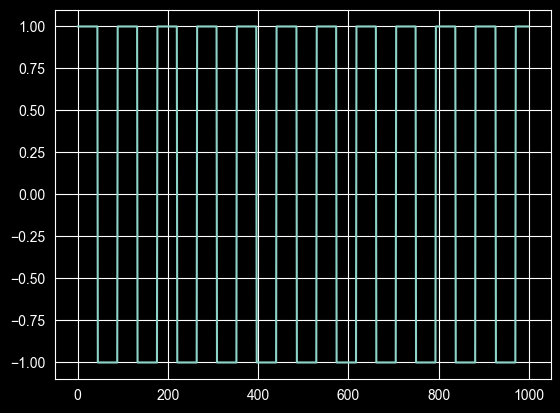

In [18]:
t = np.arange(0, 1, 1/44100)
static_signal = scipy.signal.square(2 * np.pi * 500 * t)
plt.plot(static_signal[:1000])


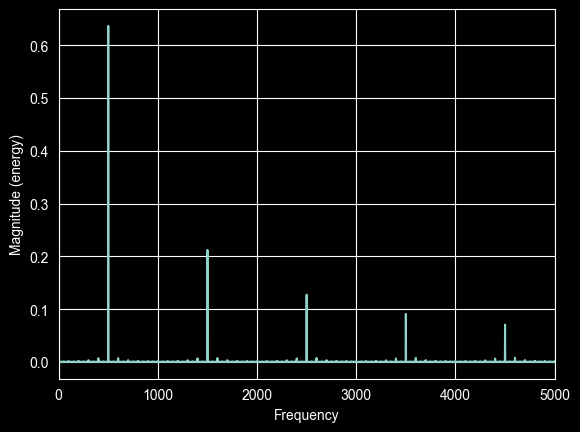

In [19]:
plt.magnitude_spectrum(static_signal,static_signal.size); 
plt.xlim(0,5000) # zoomed to show relevant output

The DFT works well for the signal above because there is no change over time. We can see all the frequencies of the square wave for the 1 sec time period.

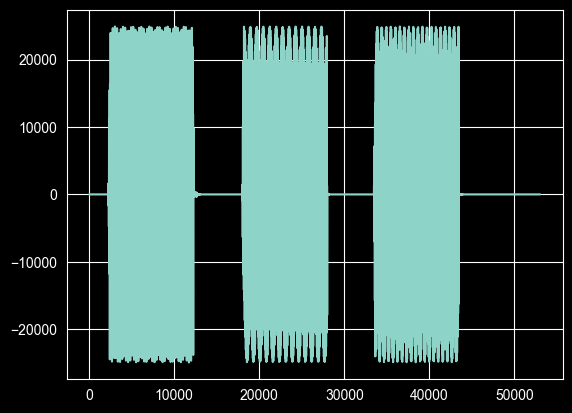

In [20]:
fs,changing_data = read('../audio/dialTones.wav')
plt.plot(changing_data)

In [21]:
Audio(changing_data, rate=44100)

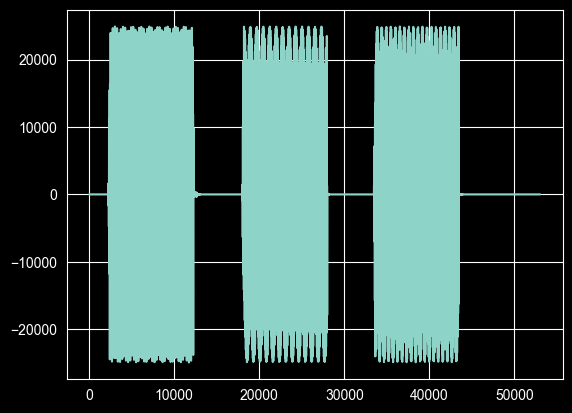

In [22]:
plt.plot(changing_data)

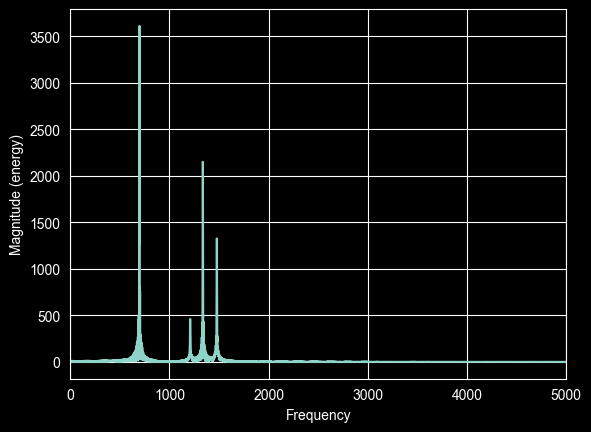

In [23]:
plt.magnitude_spectrum(changing_data,fs); 
plt.xlim(0,5000) # zoomed to show relevant output

The DFT does not work well for this signal. Although there are frequencies represented, we don't know when they happen in the signal. We just know they are occurring sometime in the 1 second time period. However, we know from listening to the file that there are 3 distinct frequency "moments". This cannot be seen with the DFT alone.

The DFT give us the spectrum of a signal over a window, but the spectrum does not include any time information! The time domain does not tell us what frequencies are present, and the frequency domain doesn't tell us anything about when frequencies occur.

### STFT

We use the Short Time Fourier Transform to determine both the "what" and "when" in the audio signal. With the STFT, we "chop up" our signal into tiny segments (or frames) then take the FT on each segment.

Let's take a look at our time-varying signal above again and see if we can get more information by taking out segments of the original signal. 

Note: We are not implementing the full STFT here, just using the concept.

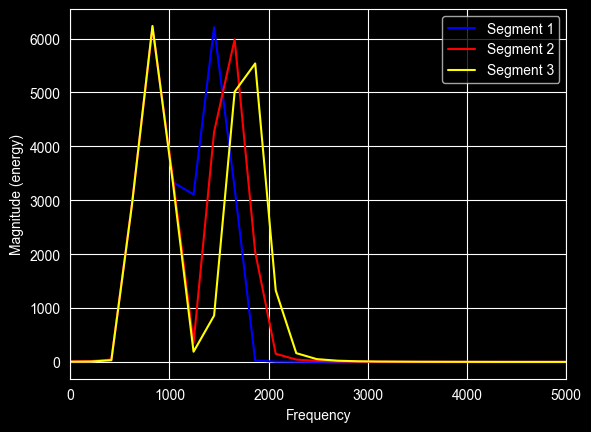

In [24]:
f1 = changing_data[2560:2816]
f2 = changing_data[18176:18432]
f3 = changing_data[37120:37376]
N = f1.size

# mx1 = my_DFT(f1/N) 
# mx2 = my_DFT(f2/N)
# mx3 = my_DFT(f3/N)

plt.magnitude_spectrum(f1, Fs=changing_data.size, color='blue', label='Segment 1')
plt.magnitude_spectrum(f2, Fs=changing_data.size, color='red', label='Segment 2')
plt.magnitude_spectrum(f3, Fs=changing_data.size, color='yellow', label='Segment 3')
plt.xlim(0,5000)
plt.legend()
plt.show()

Now, we can see a little better the how the frequencies relate to each other over time by looking at the color-coded magnitude spectrum. They all share the same lower harmonic but the upper component gets higher each time.

Though this is better, we still do not get a full picture - only which one happened first. We need to a way to line up those frequencies in time to figure out when they happened. To do that we would need to calculate the actual STFT across the full file. And we need to know the number of samples passed into our analysis frame along with the sampling rate.

Here is a representation of the STFT:

$$X[m,k] = \sum_{n=0}^{N-1} x(n + mH)w(n)\cdot e^{-j2*\pi kn/N}$$

Breaking it down, it should look similar to the DFT with a few modifications.

For the STFT, we take windowed segments of our signal and calculate the DFT. So for each windowed segment, we are taking the Fourier Transform across discrete time **n** for each discrete frequency bin **k**.

That means instead of getting one frequency vector of frequency coefficients (the X[k] spectrum output of the DFT), we get a matrix of coefficients. The STFT outputs a sequence of spectra, where the column represents time and the row represents the frequency bin.

|    | Frame 1 | Frame 2 | Frame 3 |
|---|---|---|---|
| Freq Bin 1 | complex coeff | complex coeff | complex coeff |
| Freq Bin 2 | complex coeff | complex coeff | complex coeff |
| Freq Bin 3 | complex coeff | complex coeff | complex coeff |

Back to the equation:

The *m* is the frame number or frame index. So, in the STFT not only do we iterate *k* frequency bins across *n* samples in the size *N* window. We also iterate by *m* frames to analyze our full data. This is what creates that matrix above.

*H* and *w(m)* are also new to our equation. *H* is our hop size or shift lag in samples, and *w(n)* is a windowing function. We'll talk about why we apply a window and use hop size later, but for now, understand that hop size determines how much we "shift" through the data on each iteration of *m*.

For example, if we have a frame size of 200 samples, a hop size of 100 (50%), and a signal of length 500, we'd get the following sample indices for the start of each frame:

0 (containing 0-199), 100 (containing 100-299), 200 (containing 200-399), etc

For example, if we have a frame size of 200 samples, a hop size of 0 (0%), and a signal of length 600, we'd get the following sample indices for the start of each frame:

0 (containing 0-199), 200 (containing 200-399), 400 (containing 400-599), etc


### Frequency Bins

So far when applying the DFT, we have assumed that *k* frequency was equivalent to the frequency in Hz (1-1). However, this is not true. We were just working under a specific set of constraints. Our input length *N* was always equal to our sampling rate. So, based on our understanding of Nyquist, we inherently knew to only look for frequencies at N/2 (or half the sampling rate).

What this really assumes is that all signals we've worked with so far have completed full periodicity during the course of the window. For example, a 7 Hz wave can complete a full cycle in 64 samples. Because they were the same, our sampling rate divided by N always equaled 1. This means that our "bins" were incremented as k increased (1 Hz, 2 Hz, 3 Hz, etc).

However, especially using small frames in the STFT, our frame of length N will not always be equal to our sampling rate. This means our frequency bins will not increment directly by 1. 

**The size (or resolution) of the *k* bins is equal to the sampling rate divided by N.** 
$$\Delta f = \frac{F_s}{N}$$

For example, if our frame size is 100 and sampling rate is 48000 Hz, our frequency resolution is 480 Hz. So we will be frequency bins where...
- k=0 corresponds to 0 Hz
- k=1 corresponds to 480 Hz
- k=2 corresponds to 960 Hz


if we take a smaller or larger number of samples in comparison to the size of the sampling rate (or, in this case, frame size), we change the resolution of the frequency bin.

## Spectrogram
The spectrogram is a useful tool for capturing and visualizing this time varying spectral information. Since we are looking at very small windows of time, and most often our signal will be varying more rapidly over time. Looking at the magnitude of every frame's spectrum does not give us a good impression of the data. (However, it is often the start of visualizers)

In order to represent this multidimensional data, we *color code the magnitude* of the fourier tranform, where large values are light or bright, and small values are dark. By adding the 3d dimension of color, we can represent frequency (y-axis), time (x-axis), and magnitude/power (z-axis / color).

We then lay these spectral "slices" one over top the other to form bands or rows of spectral data.  

Matplotlib has its own spectrogram function. We will learn another way to plot the spectrogram later.

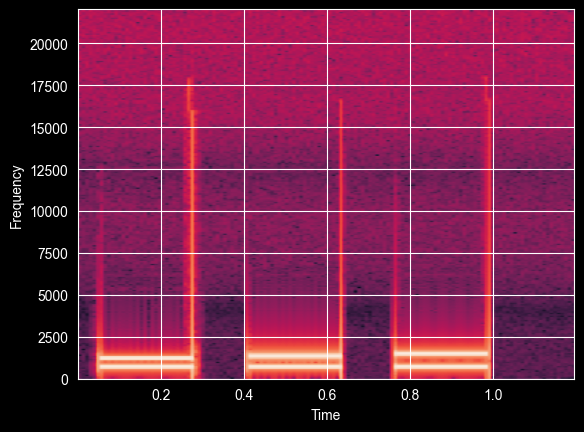

In [28]:
#matplotlib actually carries out the fourier transforms for you from your original signal
plt.specgram(changing_data, NFFT=512, Fs=44100)
plt.xlabel('Time')
plt.ylabel('Frequency')

Here is an example of our frequency content over time. We can see the bright yellow bands correspond to the frequency components of each sound burst. 

Notice our axis can be plotted with regard to the original time of the signal (because it's the same length). 

A question that might come to mind at this point is:  

**What about the length of the analysis window?**
Above I chose a window length of 256. Why? Is it the optimal size? What happens if we choose a larger window or a smaller window?  

### Spectral Leakage

When we compute **a DFT it is assuming a periodic signal**. So we are "chopping up" the signal in an STFT hoping to find small segments that don't vary much in frequency content. 

However, many times, the signal in a given window may have frequency components that **have not have traversed an integer number of periods**. 

Therefore, the
finite-ness of the measured signal may result in a truncated waveform with different
characteristics from the original continuous-time signal, and the artificial abrupt "cutting off" of the signal at the end of the window can introduce sharp
transition changes into the measured signal. 

This can create fake high frequency content. It appears as if energy at one frequency leaks into other frequencies. This phenomenon is known as **spectral leakage**, which causes the fine spectral lines to spread into
neighboring bins.

In [ ]:
N=20

x_on = np.cos(2* np.pi * 3 * np.arange(N)/N)
x_off = np.cos(2* np.pi * 3.5 * np.arange(N)/N)

nv = np.arange(N)
kv = np.arange(-N/2, N/2) 

X_on = np.array([])
#iterate over all sample indices and create complex exponential (i.e., frequency) at every k
for k in kv:
    xp = np.exp(-1j * 2 * np.pi * k * nv / N) 
    X_on = np.append(X_on, sum(x_on*xp))

X_off = np.array([])
#iterate over all sample indices and create complex exponential (i.e., frequency) at every k
for k in kv:
    xp = np.exp(-1j * 2 * np.pi * k * nv / N) 
    X_off = np.append(X_off, sum(x_off*xp))
    
plt.stem(kv, abs(X_on), linefmt='blue') 
plt.stem(kv, abs(X_off), linefmt='red')

plt.xlim(0,10) 
plt.show()

You can minimize the effects of by using a technique called **windowing** (effectively, applying an envelope function to each window of time). Windowing reduces the amplitude of the discontinuities at the boundaries of each finite sequence.

This will minimize these high frequency artifacts. 

Some common windowing functions include: rectangular, hann, blackman, blackman-harris, hamming... we will return to these later.

The most important thing to understand about the STFT is the necessary **time-frequency resolution tradeoff** which is related to the **size** of the analysis window.

### Time-Frequency tiling

STFT determines a tiling of the time-frequency plane, where the size of each tile is specified by the time and the frequency resolution of the STFT. 

So, as always, the highest positive frequency we can detect will be Fs/2 Hz, and the highest **frequency resolution** (how finely we can "resolve" any frequency components in the DFT) will be Fs/N Hz. (Where N here is the length in samples of the STFT).

Suppose we choose a window size of length 256 with a sampling rate of 44100. This leads to:
- Subdivision of time into chunks of 256 samples
- subdivision of frequency into bins where the bin width in Hz = Fs/N = 172Hz
- The number of valid frequency components (bins) = N/2 = 128

So there will be 128 frequency bins approximately 172Hz wide. This fills our full frequency range 128 x 172.265 = 22050 Hz (Nyquist)

If we change the length of the time window, suppose we take M=128, then we narrow the size of tile along the time axis, but we would therefore widen the size of the tile along the frequency axis. So now our maximum frequency resolution would be 44100/128=~344.5Hz.

You can think of each tile below as returning a unique DFT value. 

In [ ]:
from IPython.display import Image

Image('../images/time_freq.png', embed=True, width=800)

So although the shape of the tiles change, the total number of tiles remains the same, because the area of each tile remains constant.

The STFT can therefore be viewed as the output of a series of filters, or a collection of spectral sequences, each corresponding to the frequency components of x[n] falling within a particular **frequency band**

So spectrograms can be either **wideband** or **narrowband** according to the frequency resolution of the associated DFT:

**Long window: narrowband spectrogram**    
    > If our L is big, we will have more DFT points = more frequency resolution.  
    > However, in a long window, more *things* can happen in the time domain = less precision in time  

**Short window: wideband spectrogram**  
    > short L means fewer DFT points = poor frequency resolution  
    > short L means we capture many slices of time = precise location of transitions  

Depending on the kind of audio being analyzed, it can be advantageous to use a long or short window.

For example, a common use of spectrogram is in speech (and singing voice) analysis. Speech is a difficult signal to analyze. When you produce a vowel, you are producing a harmonic sound. Vowels have poor onset resolution. On the other hand, consonants have a noise-like structure, but tend to have good onset resolution. So in order to analyze a speech utterance, we need to split it into pieces and analyze them in small units.

A narrowband spectrogram is useful for extracting harmonic (or vowel) sounds. While a wideband spectrogram is useful for extracting information with fast-changing components such as noise-like (or consonant) sounds.